# DATA OVERVIEW AND STATUS REPORT

## DATA SOURCES

Our data was primarily sourced from two online resources: Yahoo finance and coin market cap

Important information:
- open 
- close 
- volume
- Daily percent change
- Weekly percent change
- Biweekly percent change
- Monthly percent change

We will use this data to compile our analysis

### How we decided on coins:
We took the top 20 coins everyday from mid August (simply an API limitation no personal bias) and appended the data frame day by day until very close to the current date of 05/04/2022

## Data Concerns and Issues 

### General Observations
- Static percentage of missing values across many coins is dependent upon the public availability of data and information
    - Note: The dates at which Yahoo Finance and CoinMarketCap initiated coverage **_do not_** represent the dates each coin was initially offered
    - Yahoo Finance and other similar sources (Google Finance, etc) source data from CoinMarketCap. This will continue to complicate efforts to fill in missing data.
- Missing data might necessitate reconsideration of the assessed time horizon
    - Historically mature coins - particularly Bitcoin - are well covered and missing data is rarely problematic
    - Newer coin offerings, including well-known ones (ETH, DOGE) have a significant portion of data missing. Time horizon must be shifted to account for the availability of public data
    - Returns in particular will be particularly difficult to manage - shrinking the studied time period will likely induce recency bias and abnormal trading events (COVID)

## The Imports

In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
from clean import data_merge
from transformDate import changeDate
import matplotlib.pyplot as plt
import glob
import os
from functools import reduce
import seaborn as sns
from corr import correlation
from winsorizer import winsorizer_with_missing

## Fixing Data Columns and Data Analysis

In [2]:
returns_df = pd.read_csv('../Data/coindata.csv')
returns_df['namelen_to_drop'] = returns_df.Symbol.str.len()
returns_df['Name'] = returns_df.apply(lambda x: x['Name'][x['namelen_to_drop']:], 1)
returns_df = returns_df.drop(['Unnamed: 0','namelen_to_drop'],axis=1)

In [3]:
final_df = returns_df[['date', 'Symbol','Price','% 24h', '% 7d']].copy()

In [4]:
final_price_df = final_df.pivot(index='date', columns='Symbol', values='Price')

In [5]:
unique_ticker = returns_df['Symbol'].nunique()

In [6]:
final_day_df = final_df.pivot(index='date', columns='Symbol', values='% 24h')

In [7]:
final_day_df.to_csv('../Data/daily_returns.csv')

In [8]:
final_price_df.to_csv('../Data/prices.csv')

In [9]:
final_week_df = final_df.pivot(index='date', columns='Symbol', values='% 7d')

## Sample Period:

Based on information from this link, we believe 2017 is an optimal time to start observing data as both the total market cap and coins are roughly 10 percent of current data. Although 10 percent is an arbitrary number, based on the explosion of crypto recently, straying further from 10% might create a sample size unrecognizable to current market conditions. Additionally, the cryptocurrency marketplace had its first spike in 2017, hitting a market cap of about 20% of what it is today. While 10% and 20% are relatively small samples, there were still over 1300 coins and over 600 billion dollars in total market capitalization, making these numbers seemingly legitimate.

While some of the top currencies have data spanning far before 2017, we recognize that the top 50 coins change frequently. Given this fact pattern, we will either need to choose the top 50 coins still trading from 2017, make the timeline coin dependent and keep the current top 50, or adjust the beginning year from 2017 to a more palatable timeline.

When a coin drops out of the top 50, we will still include it in the dataset to avoid the problem mentioned above. There will be a column in the revised dataset that notes if the coin is in the current top 50 as well as if it was in the top 50 during the trading period in the dataset. This could lead to a larger dataset than anticipated and changes to this method of thought might need to occur throughout the project’s completion.

## Data Specifications:
- Need:
    sufficient trading information (volume, open/close price, returns etc.) on each of the coins we are studying. Crypto white papers for additional information on each coin
- Have:
    - https://www.marketwatch.com/market-data/cryptocurrency
    - https://coinmarketcap.com/
    - https://www.cryptodatadownload.com/
    - https://whitepaperdatabase.com/
    - https://www.coinlore.com/crypto-sectors
    - https://www.statista.com/statistics/863917/number-crypto-coins-tokens/
    - https://www.statista.com/statistics/730876/cryptocurrency-maket-value/

## Data Cleaning

In [10]:
print(final_price_df.head(),  '\n---')
print(final_price_df.tail(),  '\n---')
print(final_price_df.columns, '\n---')
print("The shape is: ",final_price_df.shape, '\n---')
print("Info:",final_price_df.info(), '\n---') # memory usage, name, dtype, and # of non-null obs (--> # of missing obs) per variable
print(final_price_df.describe(), '\n---') # summary stats, and you can customize the list!
print("Unique Cols", final_price_df.columns.unique(), '\n---')
print("Number of Unique Coins", final_price_df.columns.nunique(), '\n---')
print("Number of days ind DF vs Actual Days: 1697/1715")

Symbol      999 AAVE  ACA  ADA ALGO  ARK ATOM AVAX      BCC      BCH  ...  \
date                                                                  ...   
2017-08-18  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  $121.08  $690.24  ...   
2017-08-19  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  $120.04  $754.56  ...   
2017-08-20  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  $116.77  $712.87  ...   
2017-08-21  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  $115.91  $599.64  ...   
2017-08-22  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  $120.44  $690.88  ...   

Symbol      WAVES WBTC      XEM  XLM     XMR      XRP  XTZ  XVG  YFI      ZEC  
date                                                                           
2017-08-18  $4.30  NaN  $0.2432  NaN  $46.69  $0.1589  NaN  NaN  NaN  $201.01  
2017-08-19  $4.43  NaN  $0.2561  NaN  $55.96  $0.1551  NaN  NaN  NaN  $233.34  
2017-08-20  $4.86  NaN  $0.2714  NaN  $54.71  $0.1587  NaN  NaN  NaN  $241.07  
2017-08-21  $4.39  NaN  $0.2525  NaN  $77.82  $0.1919  NaN  

## Highlighting Outliers --> Daily

In [11]:
daily = changeDate(final_price_df, 1)
for symbol in daily:
    daily[symbol] = daily[symbol].str.rstrip('%').astype('float') / 100.0

In [12]:
from outlier_report import *

vars_to_check = list(daily.columns.unique())
daily_report = outlier_report(daily,vars_to_check,thres=4)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,max_z_abs
Symbol,,,,,,,,,,,,,
ETC,"1,696",-0.00,1.00,-1.19,-0.50,-0.25,-0.04,-0.03,-0.02,0.18,0.51,40.60,40.60
BCN,"1,684",-0.00,1.00,-3.22,-0.07,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,40.55,40.55
NXT,"1,569",0.00,1.00,-39.59,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,39.59
BTS,"1,696",-0.00,1.00,-3.45,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,38.78,38.78
STRAT,"1,696",0.00,1.00,-6.88,-1.29,-0.02,-0.02,-0.02,-0.02,-0.02,1.00,36.70,36.70
DOGE,"1,313",0.00,1.00,-1.83,-0.40,-0.21,-0.03,-0.03,-0.03,0.16,0.77,35.52,35.52
WAVES,"1,696",-0.00,1.00,-15.34,-1.08,-0.01,-0.01,-0.01,-0.01,-0.01,1.10,34.60,34.60
MIOTA,"1,696",-0.00,1.00,-3.71,-1.78,-0.88,-0.05,-0.03,-0.03,0.84,2.07,32.61,32.61
STEEM,"1,655",0.00,1.00,-22.87,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,32.40,32.40


## Potentially Problematic Variables given their Z_Scores

In [13]:
vars_with_big_outliers = list(outlier_report(daily,vars_to_check,thres=4,return_df=True,no_print=True)
                              .query('max_z_abs > 5 & count > 0').index)

In [14]:
total_vals = daily.columns.nunique()
big_outliers = len(vars_with_big_outliers)
percent = (big_outliers/total_vals)
print('Percent with "Big Outliers" {:.2%}'.format(percent))

Percent with "Big Outliers" 84.27%


### Reality of Crypto
This perfectly encapsulates the volatility of the market. In a normal data cleaning process, these variables would almost certinaly be removed. However, crypto is inherintly extremely volatile, making this list useless in our cleaning process

## Winsorized Data --> Daily

In [15]:
(winsorizer_with_missing(daily)
 .describe(percentiles=[.01,.99])
 .T[['count','min','1%',"99%",'max']])

,count,min,1%,99%,max
Symbol,,,,,
999,858.0,-0.022392,-0.021314,0.035022,0.035316
AAVE,458.0,-0.071001,-0.070829,0.117355,0.117429
ACA,671.0,-0.001150,-0.001045,0.000590,0.000800
ADA,1651.0,-0.147200,-0.146850,0.236925,0.238150
ALGO,551.0,-0.081350,-0.077925,0.118725,0.119450
...,...,...,...,...,...
XRP,1696.0,-0.151330,-0.151302,0.248115,0.248395
XTZ,1377.0,-0.114712,-0.113563,0.148371,0.149228
XVG,1572.0,0.000000,0.000000,0.000000,0.000000


Due to this winsorization, the changed and now the min and max equal the 1/99 percentiles

## Highlighting Outliers --> Weekly

In [16]:
weekly = changeDate(final_price_df, 7)
for symbol in weekly:
    weekly[symbol] = weekly[symbol].str.rstrip('%').astype('float') / 100.0

In [17]:
from outlier_report import *

vars_to_check = list(weekly.columns.unique())
outlier_report(weekly,vars_to_check,thres=4)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,max_z_abs
Symbol,,,,,,,,,,,,,
PAY,242,0.00,1.00,-15.49,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,15.49
ETC,242,-0.00,1.00,-0.36,-0.34,-0.25,-0.07,-0.07,-0.06,0.10,0.33,15.41,15.41
ARK,238,-0.00,1.00,-15.36,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,15.36
BCN,240,-0.00,1.00,-1.54,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,15.35,15.35
PPT,226,0.00,1.00,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,14.97,14.97
WAVES,242,-0.00,1.00,-4.55,-1.21,-0.04,-0.04,-0.04,-0.04,-0.04,1.03,14.47,14.47
XVG,224,-0.00,1.00,-0.09,-0.09,-0.09,-0.09,-0.09,-0.09,-0.09,-0.09,13.62,13.62
ICX,221,0.00,1.00,-5.78,-1.55,0.01,0.01,0.01,0.01,0.01,0.01,12.78,12.78
HC,240,0.00,1.00,-8.39,-0.99,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,12.72,12.72


## Winsorized Data --> Weekly

In [18]:
(winsorizer_with_missing(weekly)
 .describe(percentiles=[.01,.99])
 .T[['count','min','1%',"99%",'max']])

,count,min,1%,99%,max
Symbol,,,,,
999,122.0,0.000000,0.000000,0.000000,0.000000
AAVE,65.0,-0.128380,-0.123081,0.449401,0.498292
ACA,95.0,-0.000120,-0.000007,0.000055,0.000924
ADA,235.0,-0.319306,-0.310532,0.896689,0.900908
ALGO,32.0,-0.124577,-0.123871,0.125160,0.140283
...,...,...,...,...,...
XRP,242.0,-0.305945,-0.302196,0.937557,0.937944
XTZ,196.0,-0.233510,-0.222481,0.395294,0.397070
XVG,224.0,0.000000,0.000000,0.000000,0.000000


Due to this winsorization, the changed and now the min and max equal the 1/99 percentiles

## Highlighting Outliers --> Biweekly

In [19]:
biweekly = changeDate(final_price_df, 14)
for symbol in biweekly:
    biweekly[symbol] = biweekly[symbol].str.rstrip('%').astype('float') / 100.0

In [20]:
from outlier_report import *

vars_to_check = list(biweekly.columns.unique())
outlier_report(biweekly,vars_to_check,thres=4)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,max_z_abs
Symbol,,,,,,,,,,,,,
ETC,121,0.00,1.00,-0.41,-0.37,-0.23,-0.10,-0.09,-0.09,0.14,0.24,10.85,10.85
BCN,120,0.00,1.00,-1.27,-0.08,-0.08,-0.08,-0.08,-0.08,-0.08,-0.08,10.80,10.80
XVG,112,-0.00,1.00,-0.09,-0.09,-0.09,-0.09,-0.09,-0.09,-0.09,-0.09,10.49,10.49
MIOTA,121,0.00,1.00,-0.88,-0.85,-0.61,-0.10,-0.07,-0.07,0.56,1.01,10.36,10.36
QTUM,121,-0.00,1.00,-1.93,-1.58,-0.87,-0.06,-0.06,-0.06,0.46,1.79,9.92,9.92
BTG,113,-0.00,1.00,-9.34,-3.46,0.13,0.13,0.13,0.13,0.13,0.13,2.00,9.34
DOGE,93,0.00,1.00,-0.33,-0.33,-0.26,-0.12,-0.12,-0.12,0.01,2.98,9.16,9.16
LSK,120,0.00,1.00,-2.89,-2.25,-0.08,-0.08,-0.08,-0.08,0.06,2.72,9.14,9.14
ICX,110,0.00,1.00,-5.49,-1.26,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,8.77,8.77


## Winsorized Data --> Biweekly

In [21]:
(winsorizer_with_missing(biweekly)
 .describe(percentiles=[.01,.99])
 .T[['count','min','1%',"99%",'max']])

,count,min,1%,99%,max
Symbol,,,,,
999,61.0,0.000000,0.000000,0.011472,0.028680
AAVE,32.0,-0.125856,-0.086841,0.444225,0.610468
ACA,47.0,0.000000,0.000000,0.000000,0.000000
ADA,117.0,-0.482276,-0.481752,2.210286,2.354188
ALGO,16.0,-0.119705,-0.117499,0.048929,0.054705
...,...,...,...,...,...
XRP,121.0,-0.438140,-0.431292,1.471496,1.562120
XTZ,98.0,-0.552621,-0.552601,0.663603,0.663690
XVG,112.0,0.000000,0.000000,0.000000,0.000000


Due to this winsorization, the changed and now the min and max equal the 1/99 percentiles

## Highlighting Outliers --> Monthly

In [22]:
monthly = changeDate(final_price_df, 30)
for symbol in monthly:
    monthly[symbol] = monthly[symbol].str.rstrip('%').astype('float') / 100.0

In [23]:
from outlier_report import *

vars_to_check = list(monthly.columns.unique())
outlier_report(monthly,vars_to_check,thres=4)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,max_z_abs
Symbol,,,,,,,,,,,,,
STRAT,56,-0.00,1.00,-7.35,-3.23,0.13,0.13,0.13,0.13,0.13,0.13,0.13,7.35
ETC,56,-0.00,1.00,-0.53,-0.51,-0.41,-0.17,-0.14,-0.11,0.23,3.57,7.23,7.23
ADA,54,-0.00,1.00,-0.51,-0.50,-0.43,-0.26,-0.17,0.03,0.33,3.56,7.04,7.04
ICX,51,0.00,1.00,-7.00,-3.43,0.14,0.14,0.14,0.14,0.14,0.14,0.14,7.00
NANO,51,0.00,1.00,-7.00,-3.43,0.14,0.14,0.14,0.14,0.14,0.14,0.14,7.00
BTG,52,-0.00,1.00,-6.94,-4.02,0.16,0.16,0.16,0.16,0.16,0.16,0.16,6.94
LSK,55,0.00,1.00,-2.04,-1.15,-0.13,-0.13,-0.13,-0.13,0.02,4.11,6.72,6.72
MIOTA,56,0.00,1.00,-1.17,-1.08,-0.94,-0.12,-0.07,-0.07,0.57,3.80,6.70,6.70
WAVES,56,-0.00,1.00,-6.58,-2.93,0.06,0.06,0.06,0.06,0.06,1.56,3.39,6.58


## Winsorized Data --> Monthly

In [24]:
(winsorizer_with_missing(monthly)
 .describe(percentiles=[.01,.99])
 .T[['count','min','1%',"99%",'max']])

,count,min,1%,99%,max
Symbol,,,,,
999,28.0,0.000000,0.000000,0.200051,0.274042
AAVE,14.0,-0.145638,-0.126705,0.000000,0.000000
ACA,0.0,NaN,NaN,NaN,NaN
ADA,54.0,-0.612095,-0.607487,3.981384,7.080288
ALGO,7.0,-0.171494,-0.168104,0.000000,0.000000
...,...,...,...,...,...
XRP,56.0,-0.445705,-0.445482,2.035197,2.129915
XTZ,45.0,-0.352152,-0.310461,0.562962,0.725340
XVG,48.0,0.000000,0.000000,0.000000,0.000000


Due to this winsorization, the changed and now the min and max equal the 1/99 percentiles

## Removing Data 

### Missing Values of Importance - Grouped by Coin - Daily

In [25]:
missing = pd.DataFrame(final_day_df.isnull().sum()/len(final_day_df))
missing = missing.rename(columns={ missing.columns[0]: 'Daily_Percent_Missing'})
missing = missing.reset_index()

missing = missing.sort_values('Daily_Percent_Missing', ascending=False)

In [26]:
missing.describe(percentiles=[.01,.05,.95,.99]).T.style.format('{:,.2f}')

,count,mean,std,min,1%,5%,50%,95%,99%,max
Daily_Percent_Missing,89.00,0.78,0.30,0.00,0.00,0.05,0.93,1.00,1.00,1.00


In [27]:
col_list = list(missing['Symbol'][missing.Daily_Percent_Missing <= 0.99])
daily = changeDate(final_price_df, 1)
daily = daily[col_list]

### Missing Values of Importance - Grouped by Coin - Weekly

In [28]:
weekly = changeDate(final_price_df, 14)
for symbol in weekly:
    weekly[symbol] = weekly[symbol].str.rstrip('%').astype('float') / 100.0

missing = pd.DataFrame(weekly.isnull().sum()/len(weekly))
missing = missing.rename(columns={ missing.columns[0]: 'Weekly_Percent_Missing'})
missing = missing.reset_index()

missing = missing.sort_values('Weekly_Percent_Missing', ascending=False)

In [29]:
missing.describe(percentiles=[.01,.05,.95,.99]).T.style.format('{:,.2f}')

,count,mean,std,min,1%,5%,50%,95%,99%,max
Weekly_Percent_Missing,89.00,0.45,0.40,0.01,0.01,0.01,0.40,1.00,1.00,1.00


In [30]:
col_list = list(missing['Symbol'][missing.Weekly_Percent_Missing <= 0.99])

In [31]:
weekly = changeDate(final_price_df, 14)
weekly = weekly[col_list]

### Missing Values of Importance - Grouped by Coin - Biweekly

In [32]:
biweekly = changeDate(final_price_df, 14)
for symbol in biweekly:
    biweekly[symbol] = biweekly[symbol].str.rstrip('%').astype('float') / 100.0

missing = pd.DataFrame(biweekly.isnull().sum()/len(biweekly))
missing = missing.rename(columns={ missing.columns[0]: 'Biweekly_Percent_Missing'})
missing = missing.reset_index()

missing = missing.sort_values('Biweekly_Percent_Missing', ascending=False)

In [33]:
missing.describe(percentiles=[.01,.05,.95,.99]).T.style.format('{:,.2f}')

,count,mean,std,min,1%,5%,50%,95%,99%,max
Biweekly_Percent_Missing,89.00,0.45,0.40,0.01,0.01,0.01,0.40,1.00,1.00,1.00


In [34]:
col_list = list(missing['Symbol'][missing.Biweekly_Percent_Missing <= 0.99])

In [35]:
biweekly = changeDate(final_price_df, 14)
biweekly = biweekly[col_list]

### Missing Values of Importance - Grouped by Coin - Monthly

In [36]:
monthly = changeDate(final_price_df, 14)
for symbol in monthly:
    monthly[symbol] = monthly[symbol].str.rstrip('%').astype('float') / 100.0

missing = pd.DataFrame(monthly.isnull().sum()/len(monthly))
missing = missing.rename(columns={ missing.columns[0]: 'Monthly_Percent_Missing'})
missing = missing.reset_index()

missing = missing.sort_values('Monthly_Percent_Missing', ascending=False)

In [37]:
missing.describe(percentiles=[.01,.05,.95,.99]).T.style.format('{:,.2f}')

,count,mean,std,min,1%,5%,50%,95%,99%,max
Monthly_Percent_Missing,89.00,0.45,0.40,0.01,0.01,0.01,0.40,1.00,1.00,1.00


In [38]:
col_list = list(missing['Symbol'][missing.Monthly_Percent_Missing <= 0.99])

In [39]:
monthly = changeDate(final_price_df, 14)
monthly = monthly[col_list]

## Plotting Correlations

### Daily

In [40]:
daily.to_csv('../Data/daily_returns.csv')

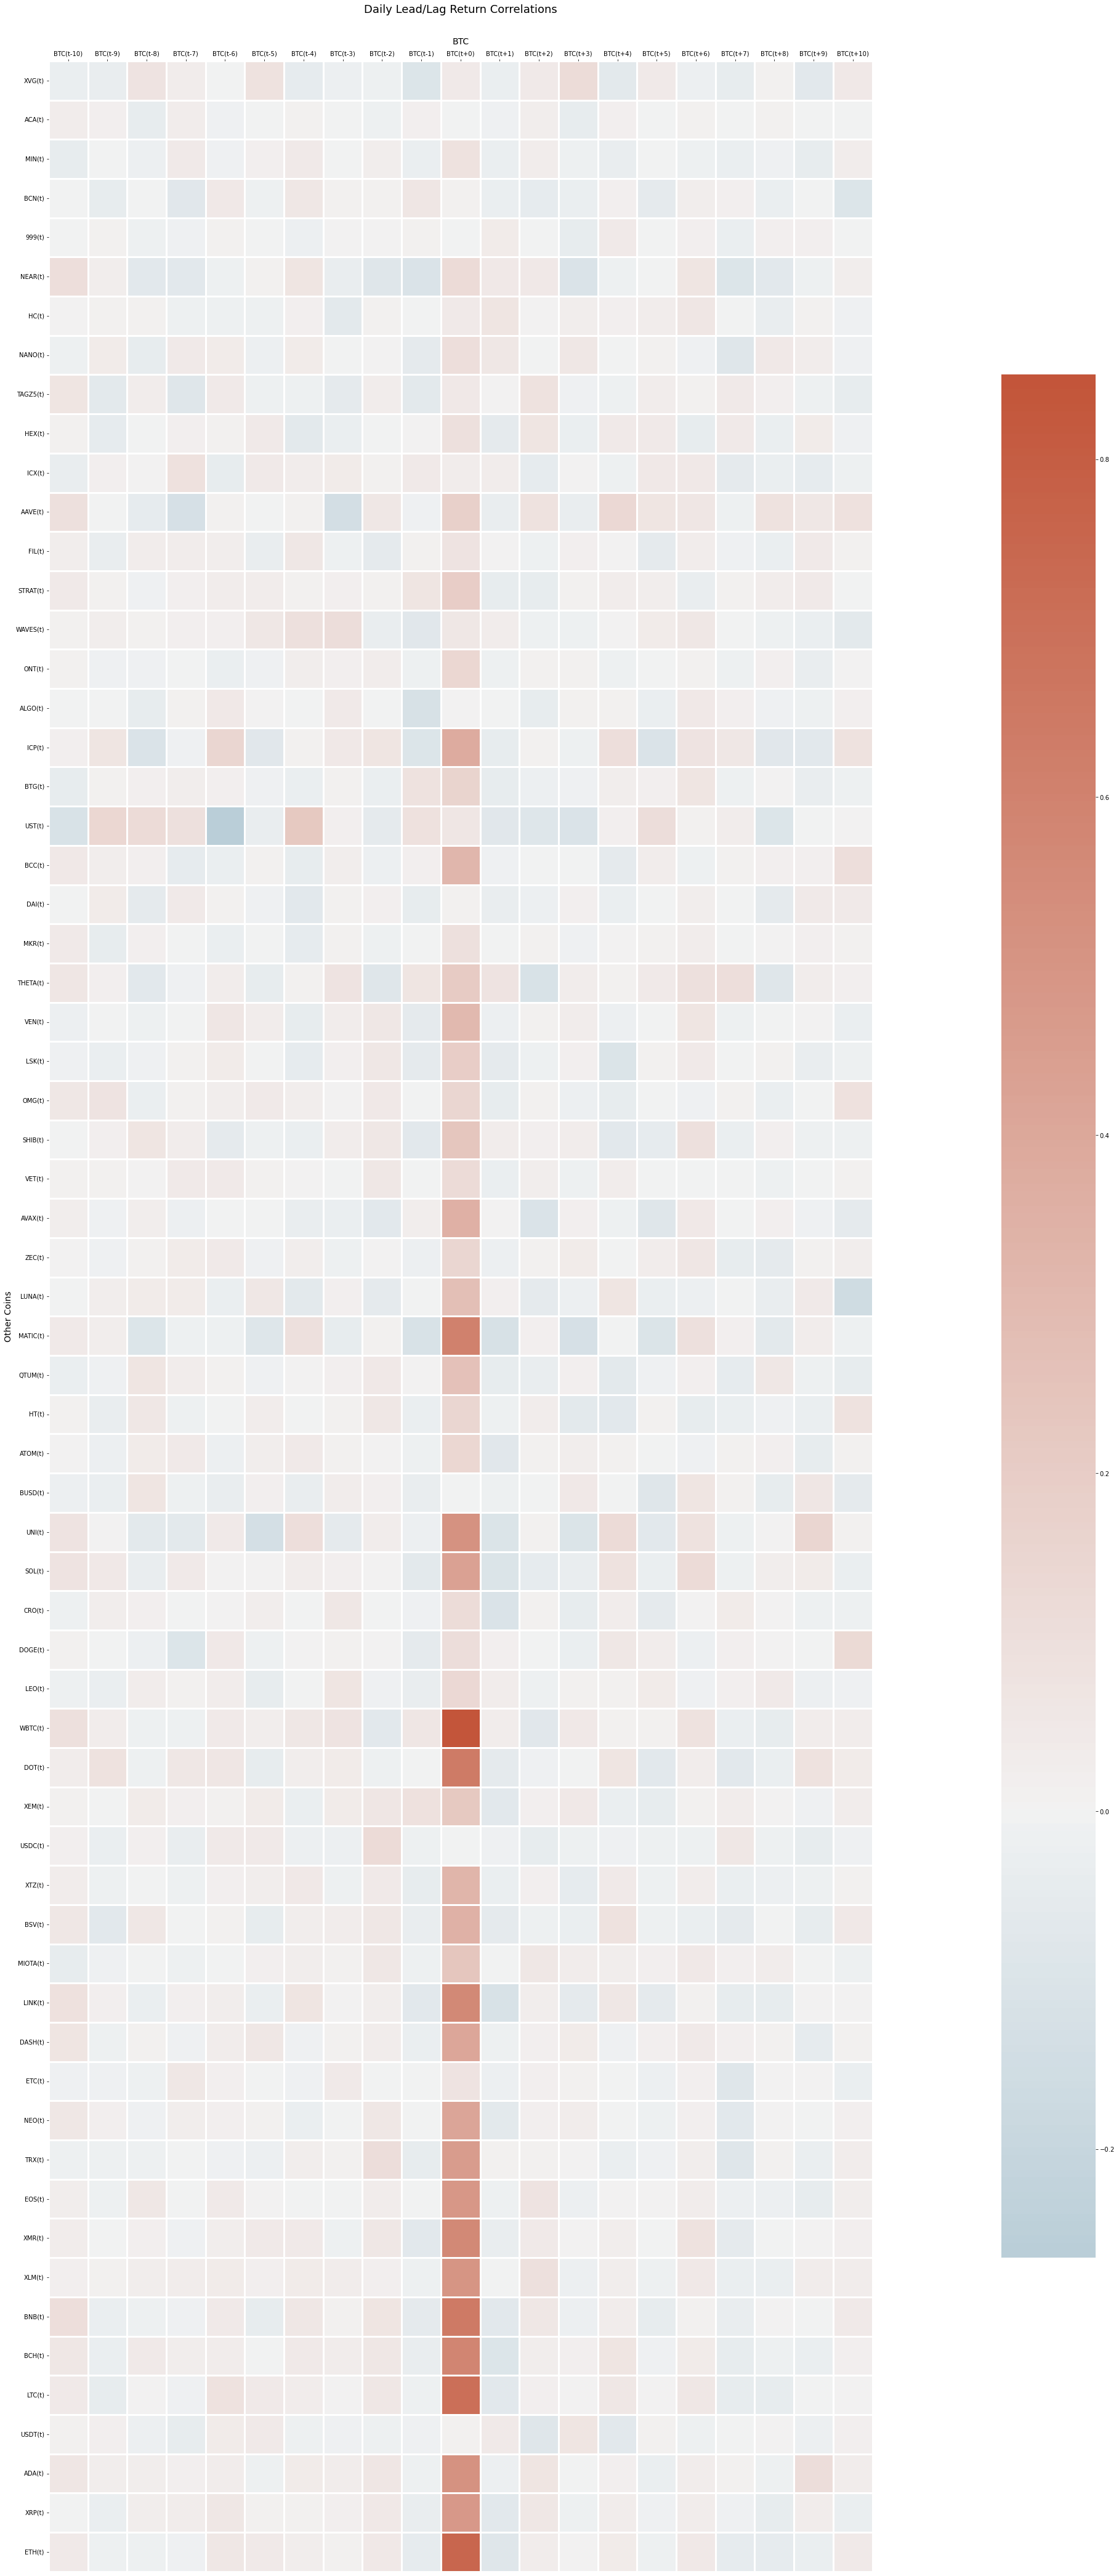

In [41]:
num = daily.columns.nunique()
plot_daily = correlation(daily,num, "Daily")
plot_daily.savefig('../Graphs/plot_daily.png')

### Weekly

In [42]:
weekly.to_csv('../Data/weekly_returns.csv')

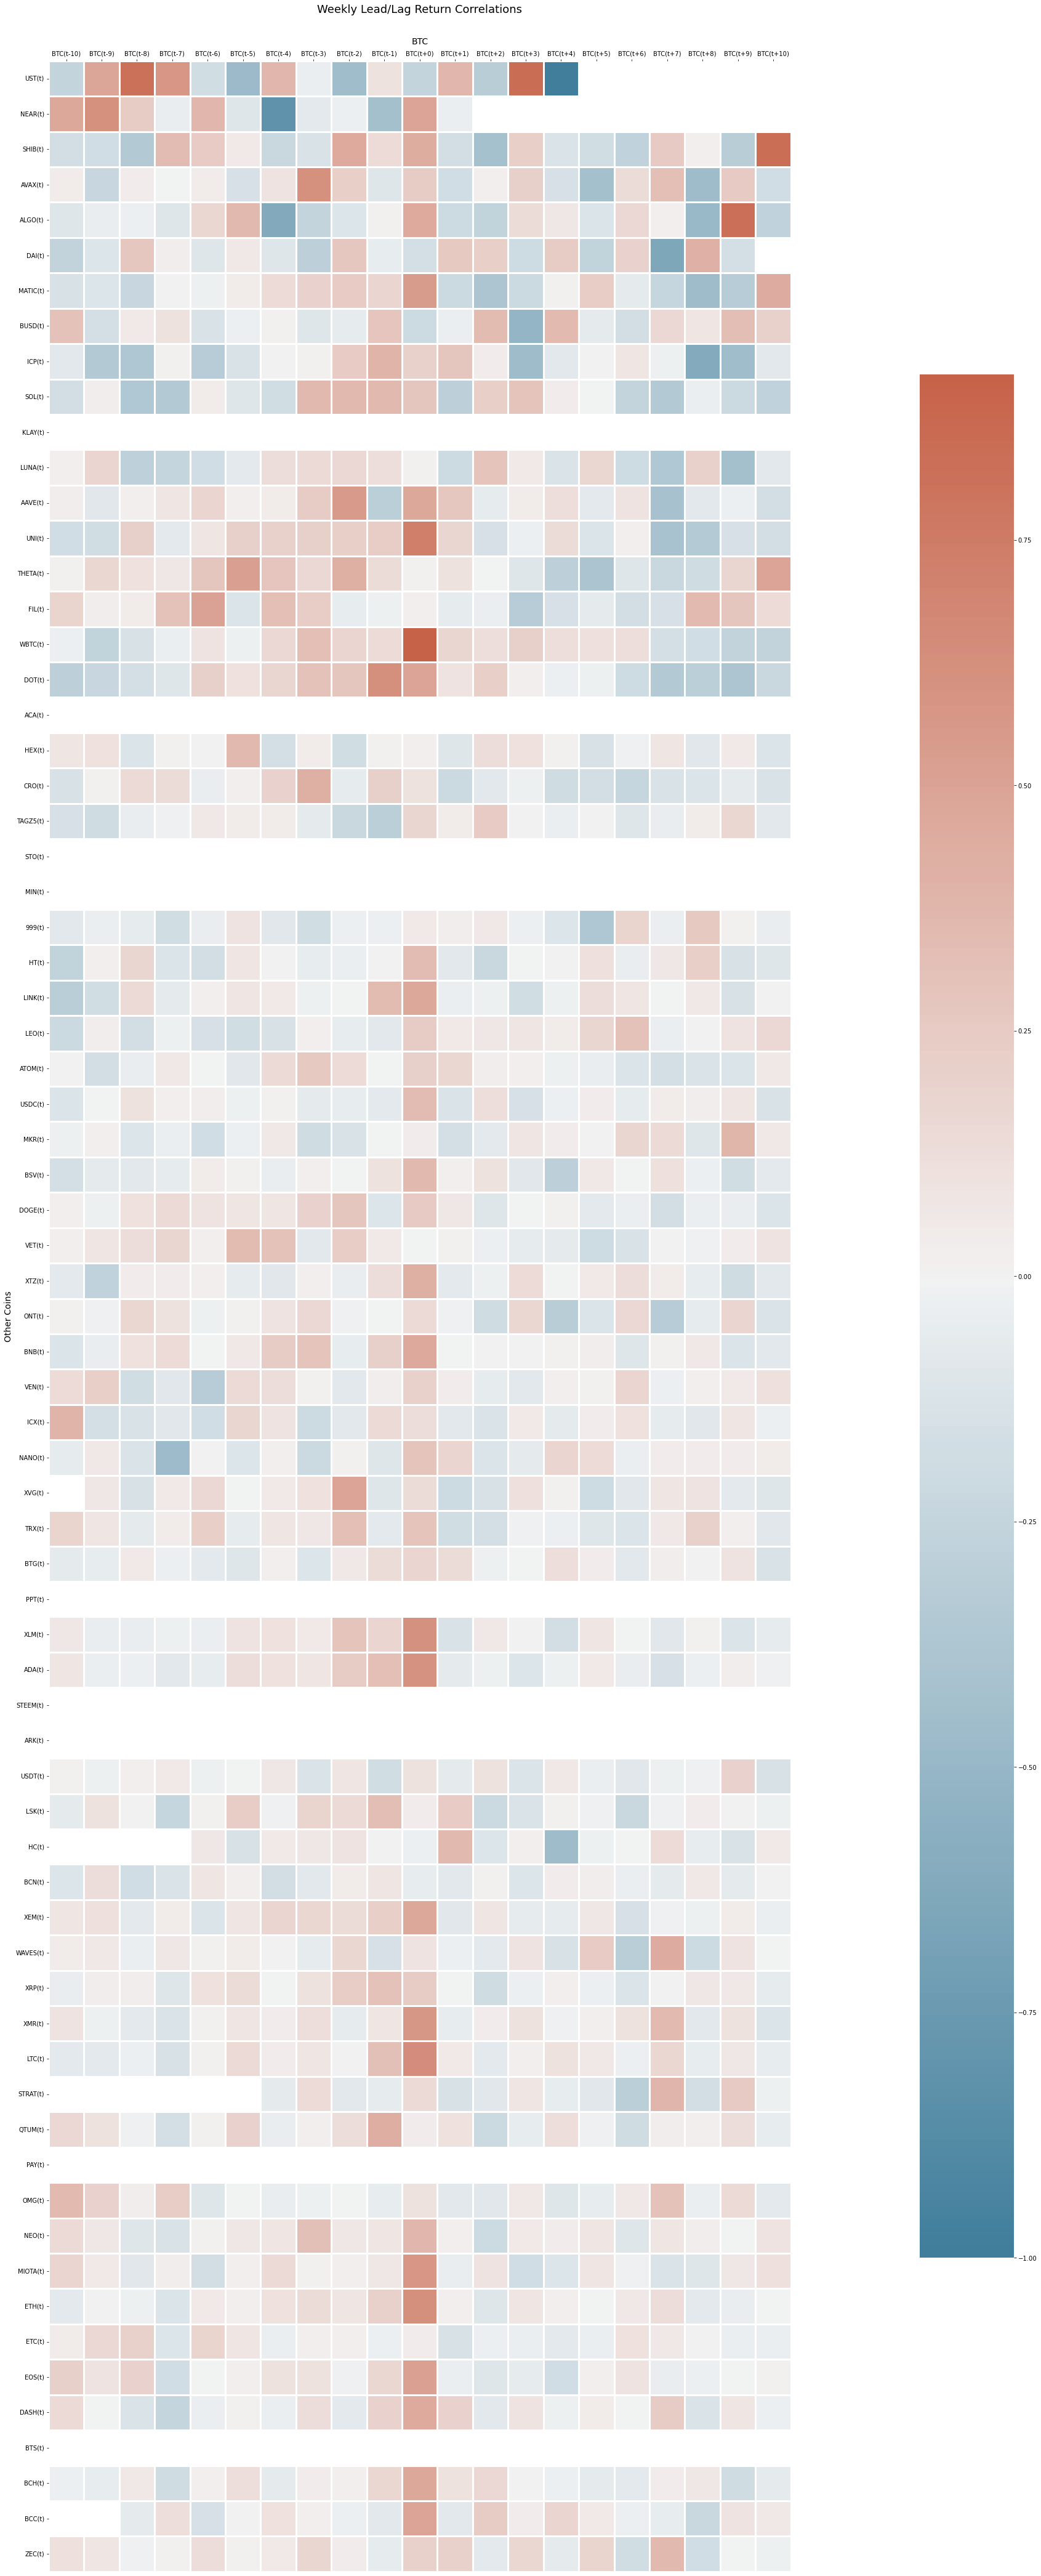

In [43]:
num = weekly.columns.nunique()
plot_weekly = correlation(weekly, num, "Weekly")
plot_weekly.savefig('../Graphs/plot_weekly.png')

### Biweekly

In [44]:
biweekly.to_csv('../Data/biweekly_returns.csv')

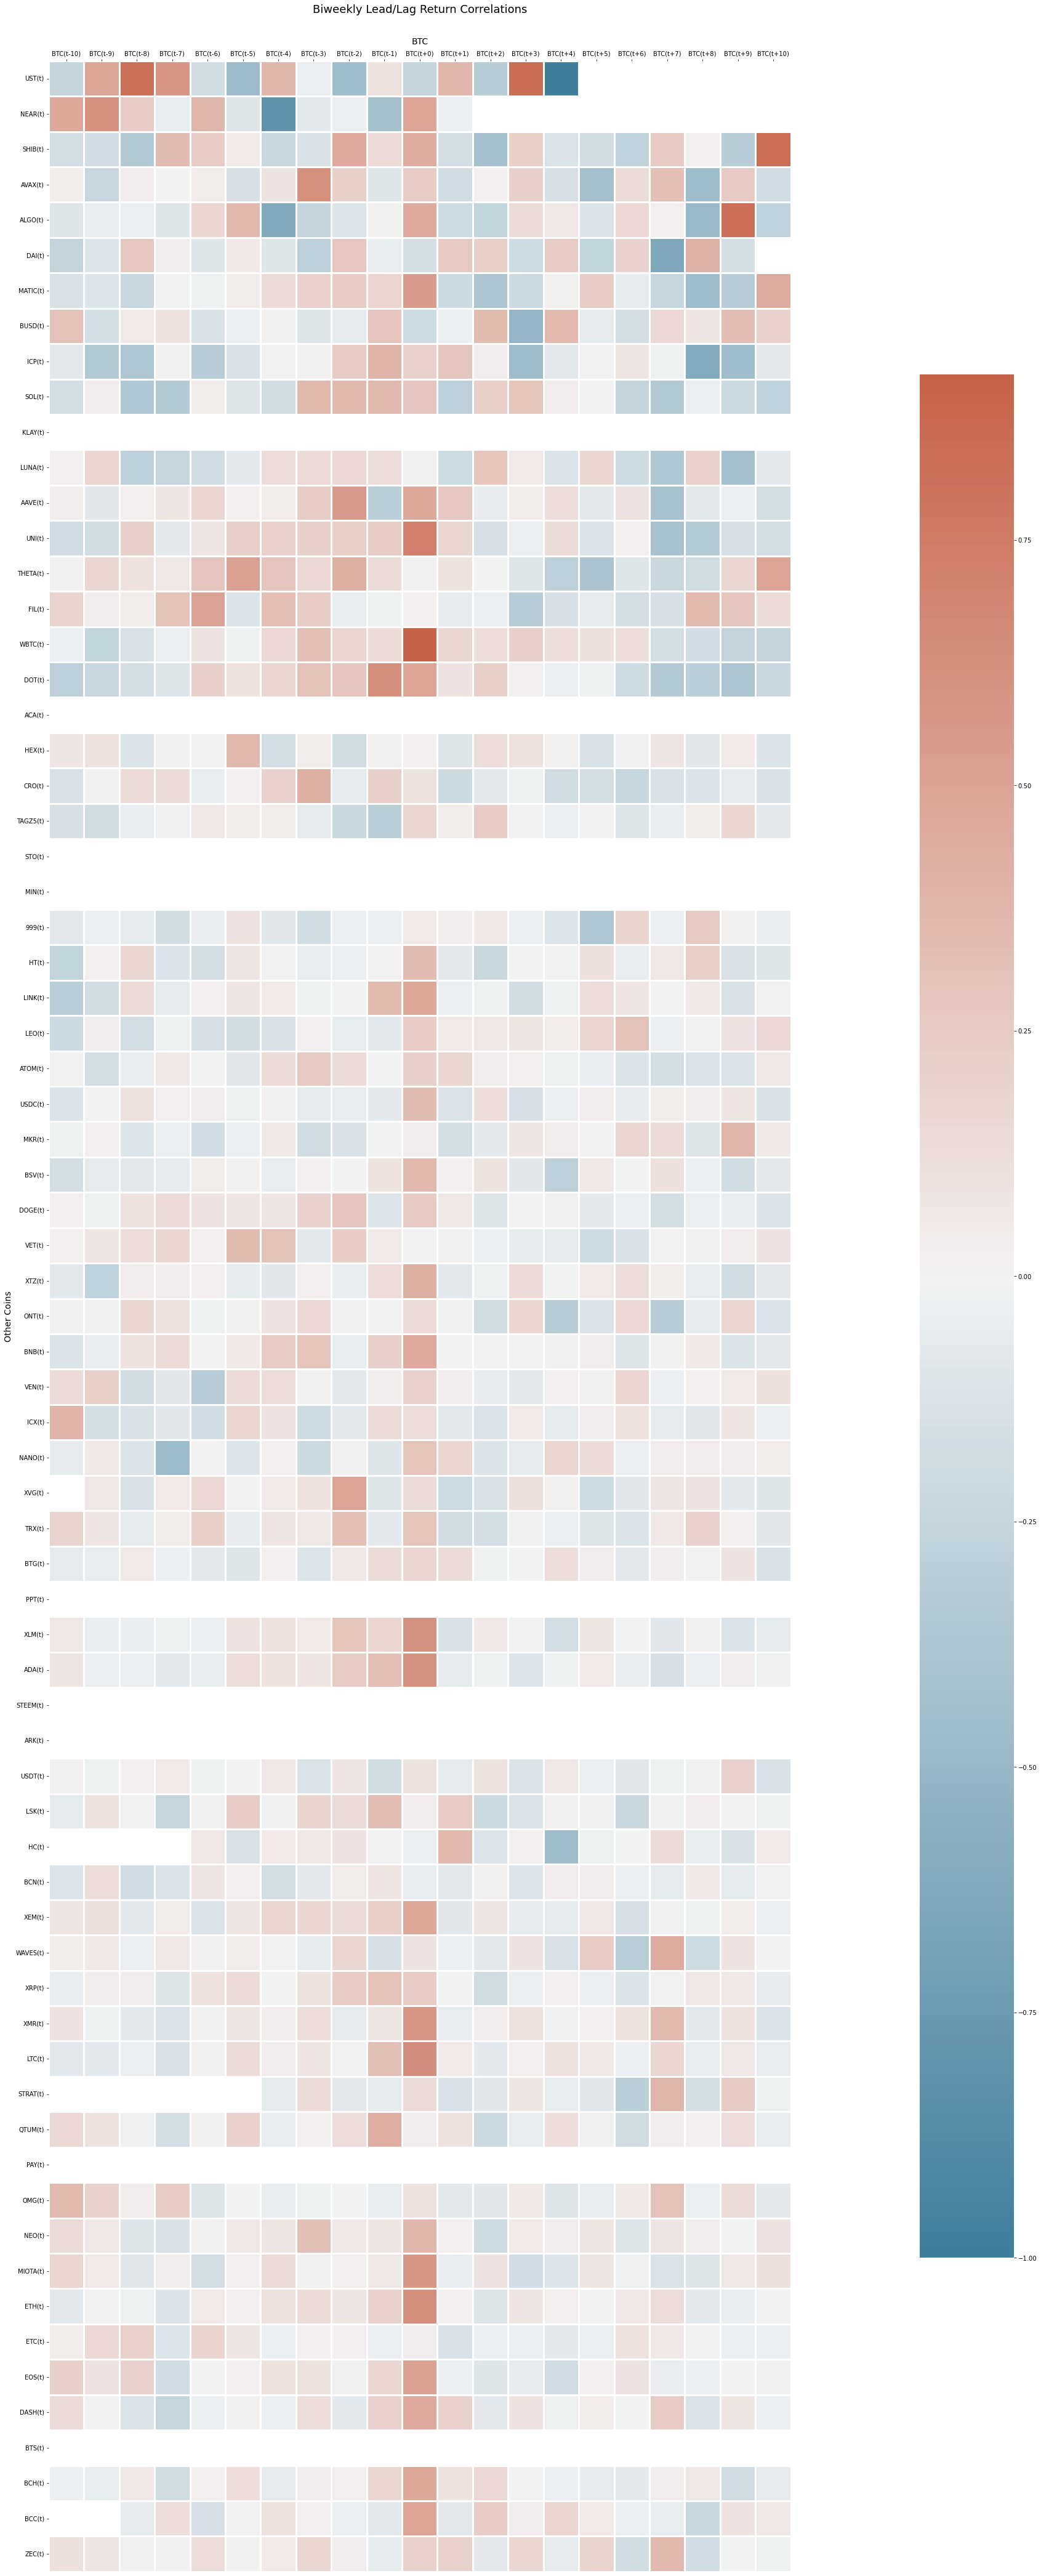

In [45]:
num = biweekly.columns.nunique()
plot_biweekly = correlation(biweekly, num, "Biweekly")
plot_biweekly.savefig('../Graphs/plot_biweekly.png')

### Monthly

In [46]:
monthly.to_csv('../Data/monthly_returns.csv')

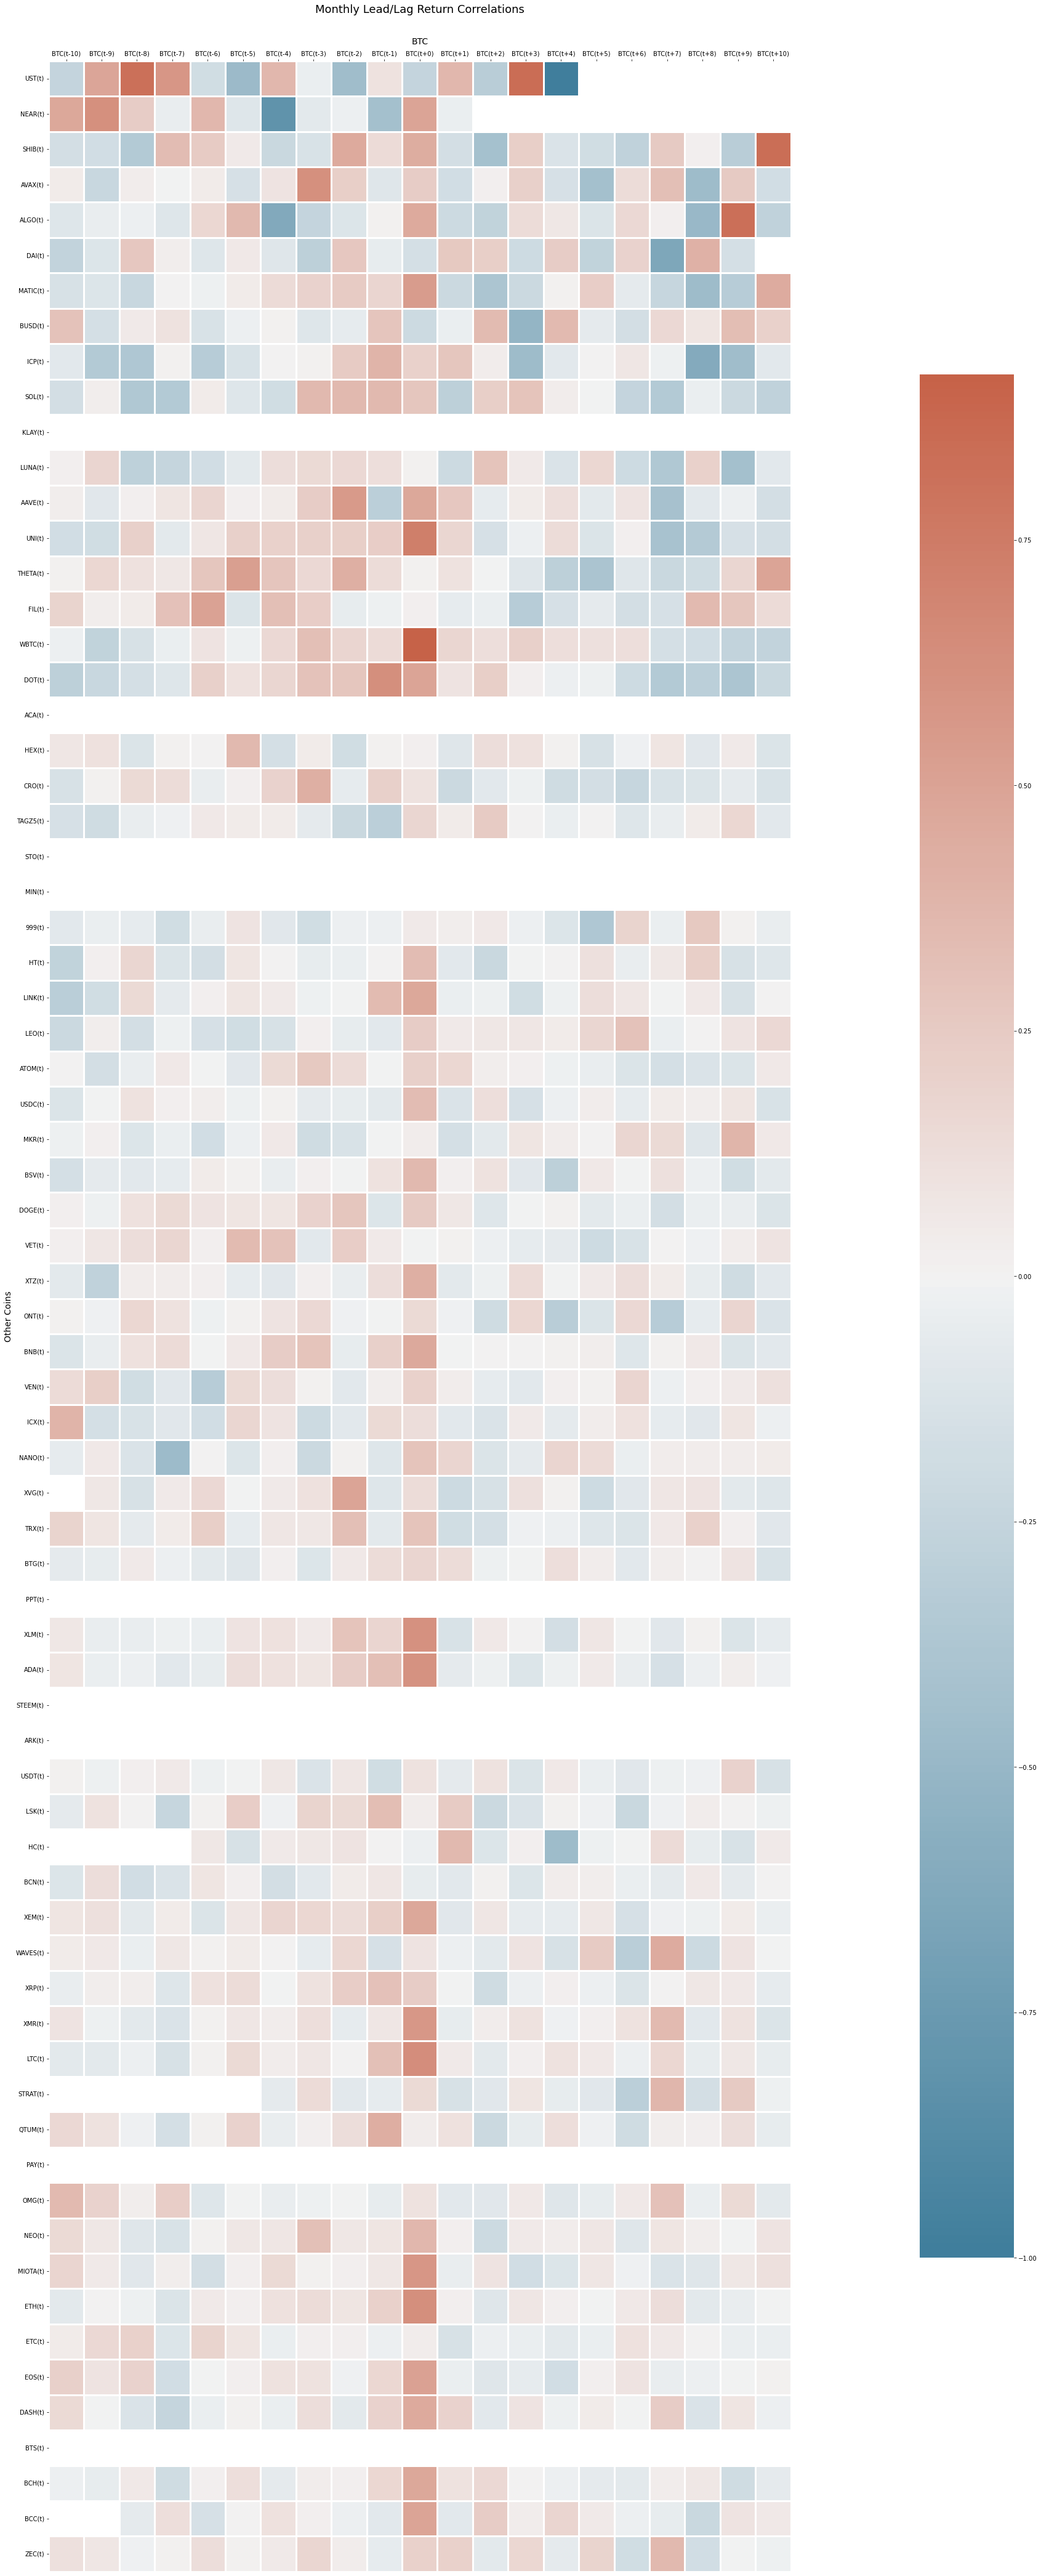

In [47]:
num = monthly.columns.nunique()
plot_monthly = correlation(monthly, num, "Monthly")
plot_monthly.savefig('../Graphs/plot_monthly.png')

## Main Findings:
- The cryptocurrency market shows no clear signs of indicator lag
- Highest correlation trading period across the board is BTC(t=0)
- Indicates market wide movements 
- Several explanations for these results exist
    - There is no lead/lag and the movement of coins is 'random'
    - Any noticeable indicators would have been priced away
    - There are indicators, but not being registered in our data set due to granularity constraints 
    - There are indicators in our data, but we failed to find them
- The highest correlation coins: Those directly tracking to BTC (Wrapped BTC)
- The lowest correlation coins: Stable coins 
    
Further Potential Projects 
- Expand data set 
- Increase granularity (Coinmarketcap has a 1hr % change application)